In [28]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, NMF, MiniBatchSparsePCA, TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN, MeanShift, OPTICS, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
import scipy.cluster.hierarchy as sch
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import SimpSOM as sms
sns.set()

In [41]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [3]:
df = pd.read_pickle('FT-data-DSpace/data_agreggated.pickle')
df = df[['Date', 'Meeting Number', 'Clean']]

In [4]:
df['Sentences'] = df['Clean'].apply(lambda x: ' '.join(x))
df['Date'] = pd.to_datetime(df['Date'])
df.sample(2)

,Date,Meeting Number,Clean,Sentences
88,2010-05-07 10:00:00,89. møde,"[mød, åbn, dag, følg, anmeld, magnus, heunick,...",mød åbn dag følg anmeld magnus heunick s m fl ...
585,2015-01-14 13:00:00,41. møde,"[mød, åbn, dag, følg, anmeld, minist, by, bol,...",mød åbn dag følg anmeld minist by bol landdist...


In [70]:
#tvec = TfidfVectorizer(min_df=.01, max_df=1.0, sublinear_tf=True, analyzer='word', ngram_range=(1,2), max_features=20000)
tvec = TfidfVectorizer(analyzer='word', ngram_range=(1,1), max_features=5000,  
                       min_df=10, max_df=0.6, sublinear_tf=True)
x = tvec.fit_transform(df['Sentences'])

words = tvec.get_feature_names()

In [71]:
df_x = pd.DataFrame(columns= words, data=x.toarray())
df_x['Date'] = df['Date']
df_x['Year'] = df_x['Date'].dt.year
df_x['Meeting'] = df['Meeting Number']
df_x.sample(2)

,3f,aaen,aaja,aalborg,aarhus,aastrup,abildgaard,abort,absurd,acceptabelt,...,østeuropa,østeuropæ,østeuropæisk,østjylland,østr,øvels,øverst,Date,Year,Meeting
753,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2016-05-31 17:00:00,2016,105. møde
788,0.019234,0.0,0.049429,0.0,0.014081,0.0,0.060626,0.0,0.019434,0.00961,...,0.011986,0.028999,0.019676,0.0,0.012165,0.008037,0.015613,2016-12-05 10:00:00,2016,28. møde


##### 

### PCA

Performing dimensionality reduction using LSA
done in 20.821871s


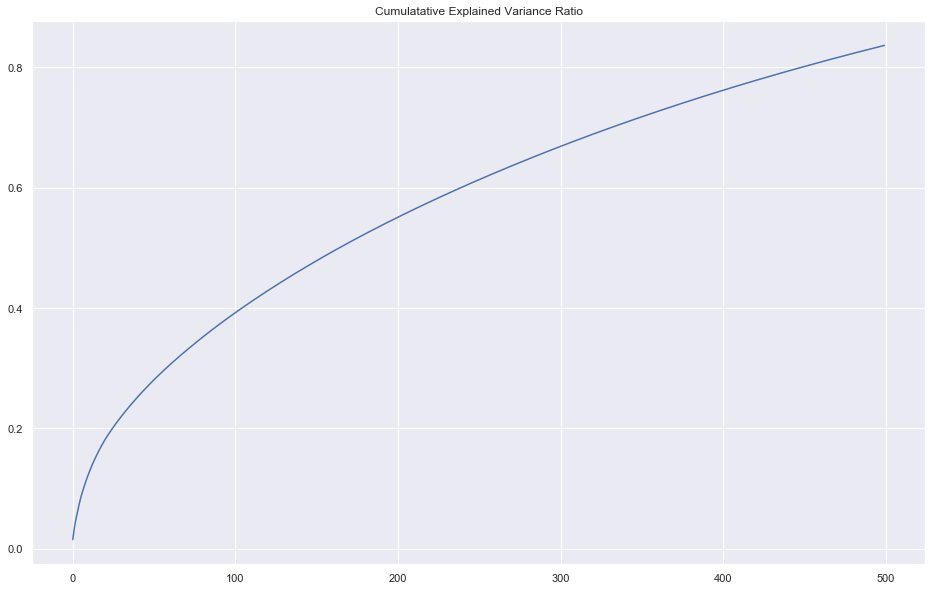

In [72]:
print("Performing dimensionality reduction using LSA")
t0 = time.time()
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(n_components=500, n_iter=100)
#normalizer = Normalizer(copy=False)
#lsa = make_pipeline(svd, normalizer)
#pca_result = lsa.fit_transform(df_x.iloc[:,:10000])


pca_result = svd.fit_transform(df_x.iloc[:,:5000])
df_x['pca-one'] = pca_result[:,0]
df_x['pca-two'] = pca_result[:,1] 
df_x['pca-three'] = pca_result[:,2]#

print("done in %fs" % (time.time() - t0))
plt.figure(figsize=(16,10))
plt.title('Cumulatative Explained Variance Ratio')
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.show()

### K-means clustering 

In [81]:
### GAP STATISTICS
k, gapdf = optimalK(pca_result, nrefs=5, maxClusters=33)
print ('Optimal k is: ', k)

Optimal k is:  31


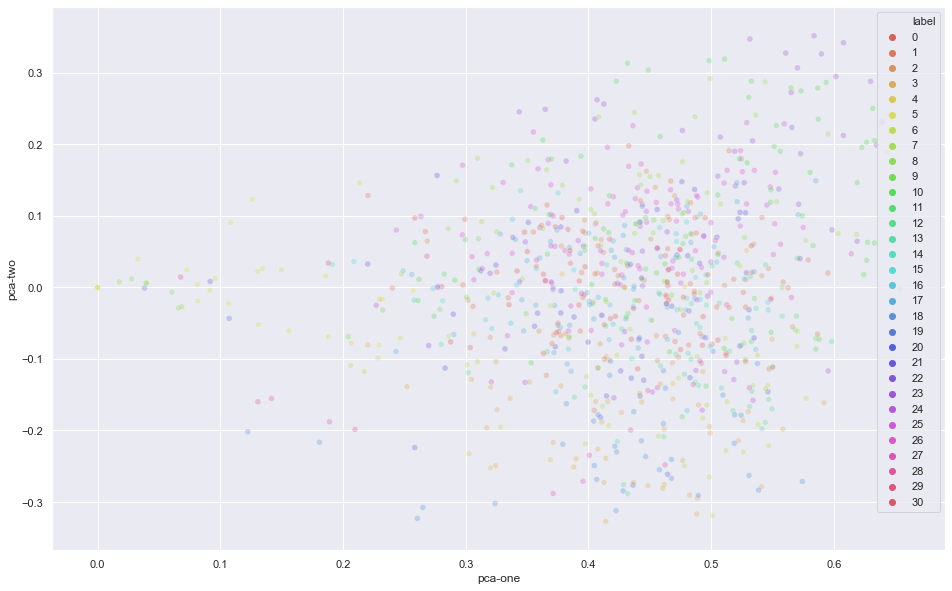

In [82]:
clustering = KMeans(n_clusters=31, n_init=100, max_iter=2000, algorithm='full').fit(pca_result)
df_x['label'] = clustering.labels_

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue='label',
    palette=sns.color_palette("hls", np.max(clustering.labels_)+1),
    data=df_x,
    legend="full",
    alpha=0.3
)

<Figure size 1152x720 with 0 Axes>

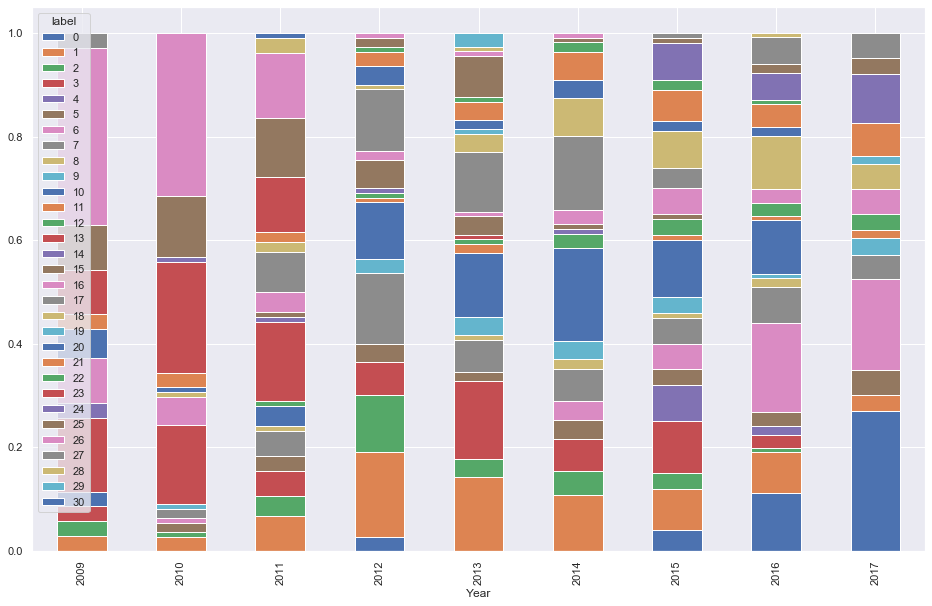

In [83]:
plt.figure(figsize=(16,10))
df_ = df_x.groupby(['Year', 'label'])['Meeting'].count().unstack()
df_ = df_.div(df_.sum(axis=1),axis=0).plot(kind='bar', stacked=True,  figsize=(16,10))
plt.show()

In [84]:
original_space_centroids = svd.inverse_transform(clustering.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tvec.get_feature_names()
for i in range(np.max(clustering.labels_)+1):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s,' % terms[ind], end='')
    print()

Cluster 0: elev, oplæsning, boligminist, videregå, medspørg, forskningsminist, kaar, dybvad, folkeskol, undervisning,
Cluster 1: hyllested, henning, kristian, selskab, pihl, trafik, mik, lorentz, kollektiv, birk,
Cluster 2: dohn, udlej, stofmisbrug, stofindtagelsesrum, elholm, schack, louis, alm, oles, birk,
Cluster 3: kriminalit, kriminel, lauritz, skip, forbryd, behnk, domstol, fængsel, retsudvalg, justitsministeri,
Cluster 4: sandbæk, flygtning, knuth, marcus, ulla, integrationsyd, asyl, asylansøg, frihedsberøv, sofi,
Cluster 5: oglovforslag, grønland, torsdag, ungeyd, tiltråd, bygningsminist, kong, enstem, færø, septemb,
Cluster 6: flygtning, asylansøg, integration, marcus, knuth, opholdstillad, udlænding, asyl, fock, niels,
Cluster 7: bøgsted, kontanthjælp, dagpeng, joachim, bent, arbejdsløs, juhl, dagpengeperiod, dagpengesystem, beskæftigelsesminist,
Cluster 8: onsdag, forretningsorden, august, førstebehandling, folkestyr, grundlov, forind, tjenest, investeringsforening, kong,
Cl

### Self Organizing Maps

In [31]:
net = sms.somNet(10, 10, pca_result)
net.train(0.01, 20000)
net.nodes_graph(colnum=0)


Periodic Boundary Conditions inactive.
The weights will be initialised randomly.
Training SOM... 10% 

KeyboardInterrupt: 

In [ ]:
prj=np.array(net.project(pca_result))

clustering = KMeans(n_clusters=20, n_init=30, max_iter=2000, algorithm='full').fit(prj)
df_x['label'] = clustering.labels_

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue='label',
    palette=sns.color_palette("hls", np.max(clustering.labels_)+1),
    data=df_x,
    legend="full",
    alpha=0.3
)

In [ ]:
plt.figure(figsize=(16,10))
df_ = df_x.groupby(['Year', 'label'])['Meeting'].count().unstack()
df_ = df_.div(df_.sum(axis=1),axis=0).plot(kind='bar', stacked=True,  figsize=(16,10))
plt.show()

In [ ]:
original_space_centroids = svd.inverse_transform(clustering.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tvec.get_feature_names()
for i in range(np.max(clustering.labels_)+1):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

### Agglomerative Clustering

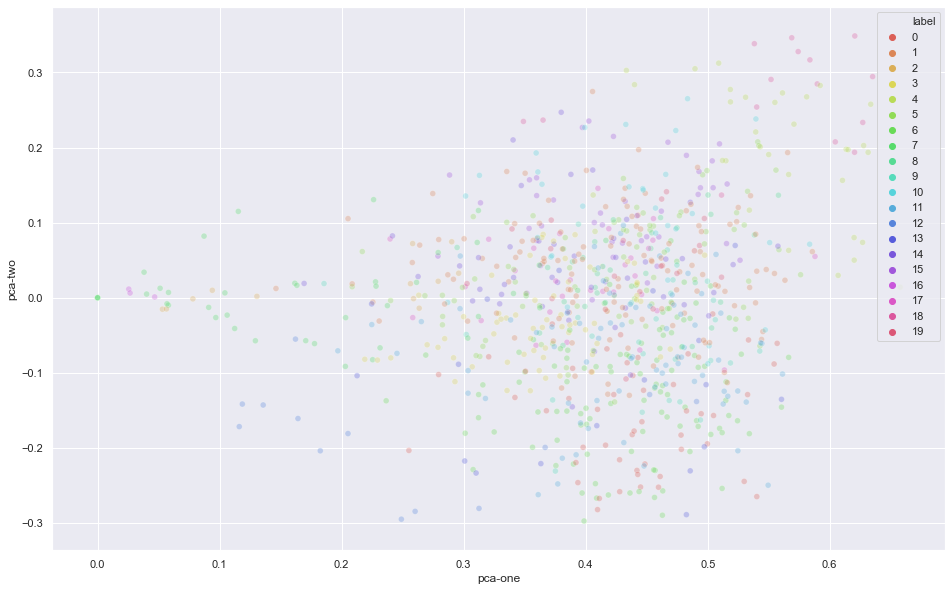

In [124]:

clustering = AgglomerativeClustering(n_clusters=20, compute_full_tree=True).fit(pca_result)
df_x['label'] = clustering.labels_

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue='label',
    palette=sns.color_palette("hls", np.max(clustering.labels_)+1),
    data=df_x,
    legend="full",
    alpha=0.3
)

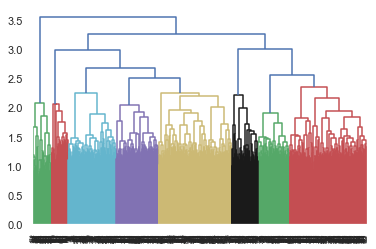

In [39]:
dendrogram = sch.dendrogram(sch.linkage(pca_result, method='ward'))

### Archive

In [ ]:
#Code For Elbow Method
nc = range(40,70,5)
kmeans = [KMeans(n_clusters = i, n_init = 10, max_iter = 100, algorithm='full') for i in nc]
score = [kmeans[i].fit(pca_result).inertia_ for i in range(len(kmeans))]
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show() ## to find the most optimal K -> optimal K is when the graph levels off


In [60]:
k = 10
#kmeans = KMeans(n_clusters=3).fit(df_x[words])
kmeans = KMeans(n_clusters=k, n_init=10, max_iter=2000, algorithm='full').fit(pca_result)
df_x['label'] = kmeans.labels_

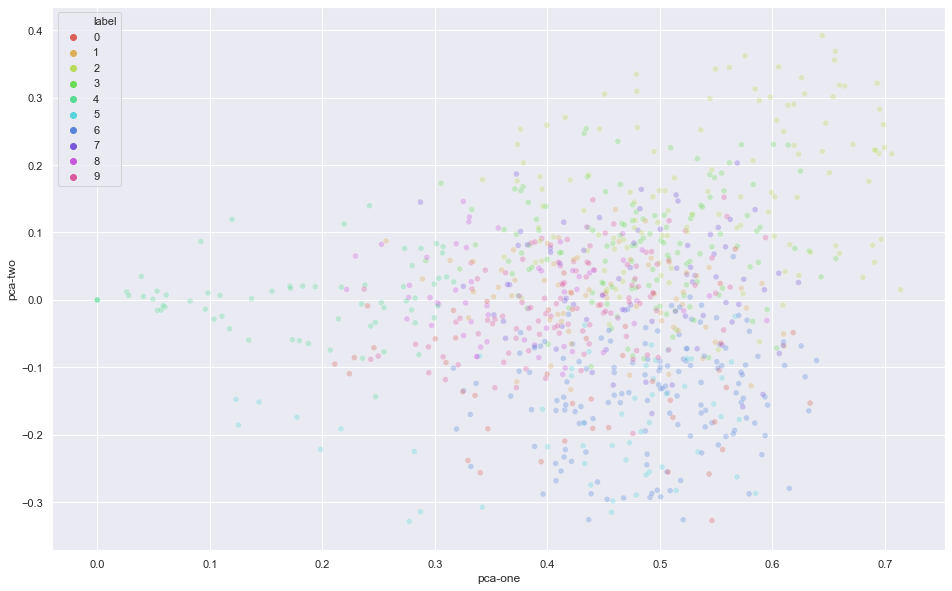

In [61]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue='label',
    palette=sns.color_palette("hls", k),
    data=df_x,
    legend="full",
    alpha=0.3
)

#### T-SNE

In [62]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000)
#tsne_results = tsne.fit_transform(df_x[words])
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 863 samples in 0.086s...
[t-SNE] Computed neighbors for 863 samples in 0.608s...
[t-SNE] Computed conditional probabilities for sample 863 / 863
[t-SNE] Mean sigma: 0.295880
[t-SNE] KL divergence after 250 iterations with early exaggeration: 159.161560
[t-SNE] KL divergence after 1000 iterations: 3.105813
t-SNE done! Time elapsed: 4.813013553619385 seconds


In [63]:
df_x['tsne_component_one'] = tsne_results[:,0]
df_x['tsne_component_two'] = tsne_results[:,1]

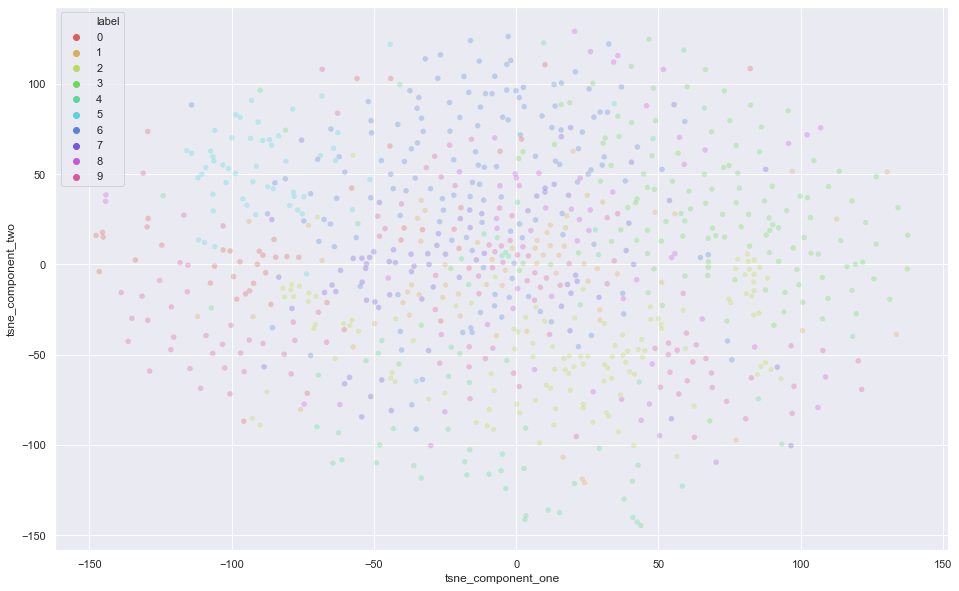

In [64]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_component_one", y="tsne_component_two",
    hue='label',
    palette=sns.color_palette("hls", k),
    data=df_x,
    legend="full",
    alpha=0.3
)

<Figure size 1152x720 with 0 Axes>

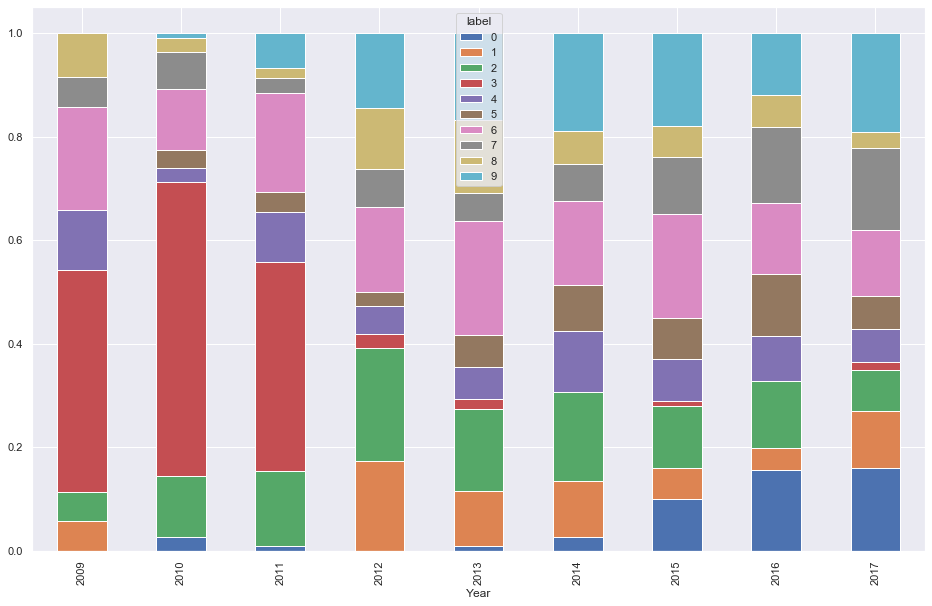

In [65]:
plt.figure(figsize=(16,10))
df_ = df_x.groupby(['Year', 'label'])['Meeting'].count().unstack()
df_ = df_.div(df_.sum(axis=1),axis=0).plot(kind='bar', stacked=True,  figsize=(16,10))
plt.show()

In [67]:
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tvec.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: flygtning asylansøg knuth marcus asyl integration johan integrationsyd sofi opholdstillad
Cluster 1: elev folkeskol undervisning ahrendts alex forældr rosa meret riisag dohn
Cluster 2: arbejdsløs skattelet dagpeng kontanthjælp reform skattereform dagpengeperiod dagpengesystem oles forsørg
Cluster 3: barfod lausts per anders lin bjarn indenr region sundhedsminist sophi
Cluster 4: onsdag kong ændringsforslag oktob nyvalg august grønland færø kf udvalgsbehandling
Cluster 5: udenrigsminist militær isil irak syri fn civil soldat nato krig
Cluster 6: justitsminist politi kriminalit kriminel domstol forbryd straf forslagsstil behnk fængsel
Cluster 7: co2 fossil omstilling energi pso vedvar grøn energipolitik udledning klima
Cluster 8: patient sundhedsvæs sundhedsvæsen sundhedsstyr region sophi sygdom ændringsforslag sundhedsminist blixt
Cluster 9: medspørg justitsminist transportminist politi oplæsning skatteminist finansminist pet skaarup spørgetid


In [68]:
#### make per meeting agenda